In [63]:
import numpy as np
import pandas as pd
import scipy as sp

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.color'] = 'black'
plt.rcParams['text.fontweight'] = 'bold'
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.shadow'] = False
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.fontsize'] = 10

font = {'weight' : 'normal',
      'size'   : 12}

plt.rc('font', **font)

import fair
fair.__version__

'1.0.1'

In [83]:
forc_file = './fair/RCPs/RCP85_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)

concs_filem = './fair/GCP_data/RCP85_MIDYEAR_CONCENTRATIONS.csv'
concs_datam = np.genfromtxt(concs_filem,skip_header=37,delimiter=',',names=True)

emms_file = './fair/RCPs/RCP85_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

nat_emms_file = './fair/RCPs/RCP85_NAT_EMISSIONS.csv'
nat_emms_data = np.genfromtxt(nat_emms_file,skip_header=0,delimiter=',',names=True)



out_for_T = fair.forward.fair_scm(emissions=emms_data['FossilCO2'] + emms_data['OtherCO2'],
                                    M_emissions=emms_data['CH4'] + nat_emms_data['CH4'],
                                    N_emissions=(emms_data['N2O'] + nat_emms_data['N2O']) * 44./28.,
                                    other_rf=forc_data['TOTAL_INCLVOLCANIC_RF'] - forc_data['N2O_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'], MAGICC_model = True,
                                    S_OH_CH4 = -0.28, S_T_CH4 = 0.0316, tau_M_0 = 9.0,tau_N_0=121.0,
                                    in_state = [[0.0,0.0,0.0,0.0],[0.0,0.0],0.0,722.0,273.0,[0.0,0.0,0.0,0.0,0.0,0.0]])

N_concs = concs_datam['N2O']
M_concs = concs_datam['CH4']

S_OH_CH4 = -0.28
S_T_CH4 = 0.0316
tau_M_0 = 9.0
tau_N_0=121.0
S_N2O = -0.05
N_0 = 273.0
M_0 = 722.0
N_pre = 273.0
M_pre = 722.0
ppb_MtN2O = 7.559
ppb_MtCH4 = 2.78

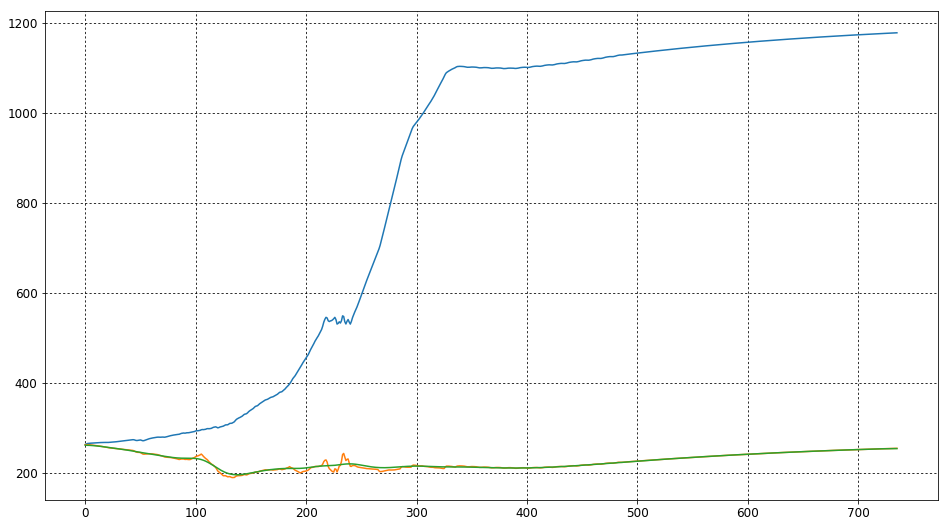

In [84]:
#CH4 inversion

M_emissions = np.zeros(M_concs.size)
M_concs = np.insert(M_concs,0,M_pre)
T = out_for_T['temperature']
T = np.insert(T,0,0.0)

tropOH = S_OH_CH4 * (np.log(M_concs) - np.log(M_0))
tau_1 = tau_M_0 * np.exp(-1*tropOH)
tau_CH4_trop = tau_M_0 / ((tau_M_0 / tau_1) + S_T_CH4 * T)
tau_M = (1/tau_CH4_trop + 1/120.0 + 1/150.0 + 1/200.0)**(-1)

tau_M = np.delete(tau_M , -1)

for i,x in enumerate(M_concs):
    if i == M_concs.size -1 :
        break
    else:
        M_emissions[i] = ppb_MtCH4 * (M_concs[i+1] - x * np.exp(-1/tau_M[i])) / ((tau_M[i]) * (1-np.exp(-1/tau_M[i])))
        
plt.plot(M_emissions)

CH4_nat_emms = M_emissions - emms_data['CH4']

plt.plot(CH4_nat_emms)
plt.plot(nat_emms_data['CH4'])


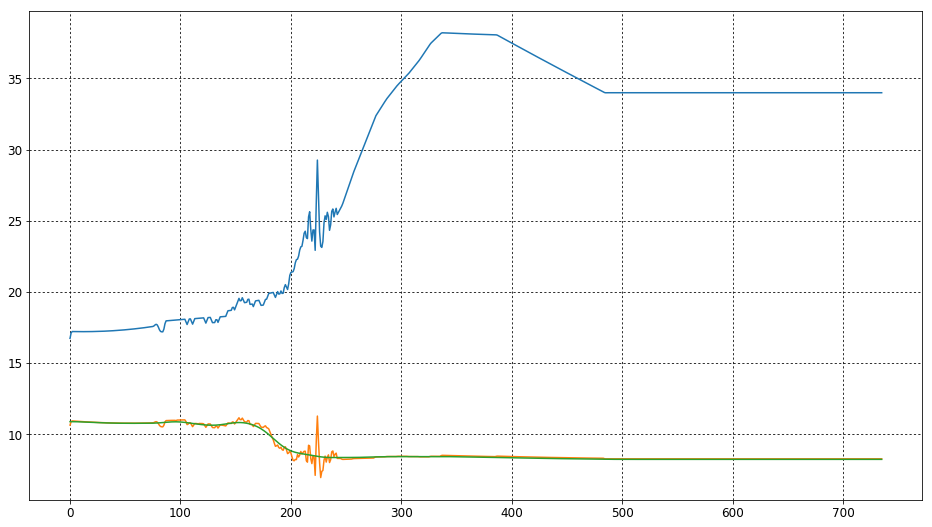

In [85]:
#N2O inversion

N_emissions = np.zeros(N_concs.size)
N_concs = np.insert(N_concs , 0 , N_pre)

tau_N = tau_N_0 * (N_concs / N_0) ** S_N2O

tau_N = np.delete(tau_N , -1)

for i,x in enumerate(N_concs):
    if i == N_concs.size-1:
        break
    else:
        N_emissions[i] = ppb_MtN2O * (N_concs[i+1] - x * np.exp(-1/tau_N[i])) / ((tau_N[i]) * (1-np.exp(-1/tau_N[i])))
        
plt.plot(N_emissions)
    
N2O_nat_emms = (N_emissions - emms_data['N2O'] * 44./28. ) *28./44.

plt.plot(N2O_nat_emms)
plt.plot(nat_emms_data['N2O'])

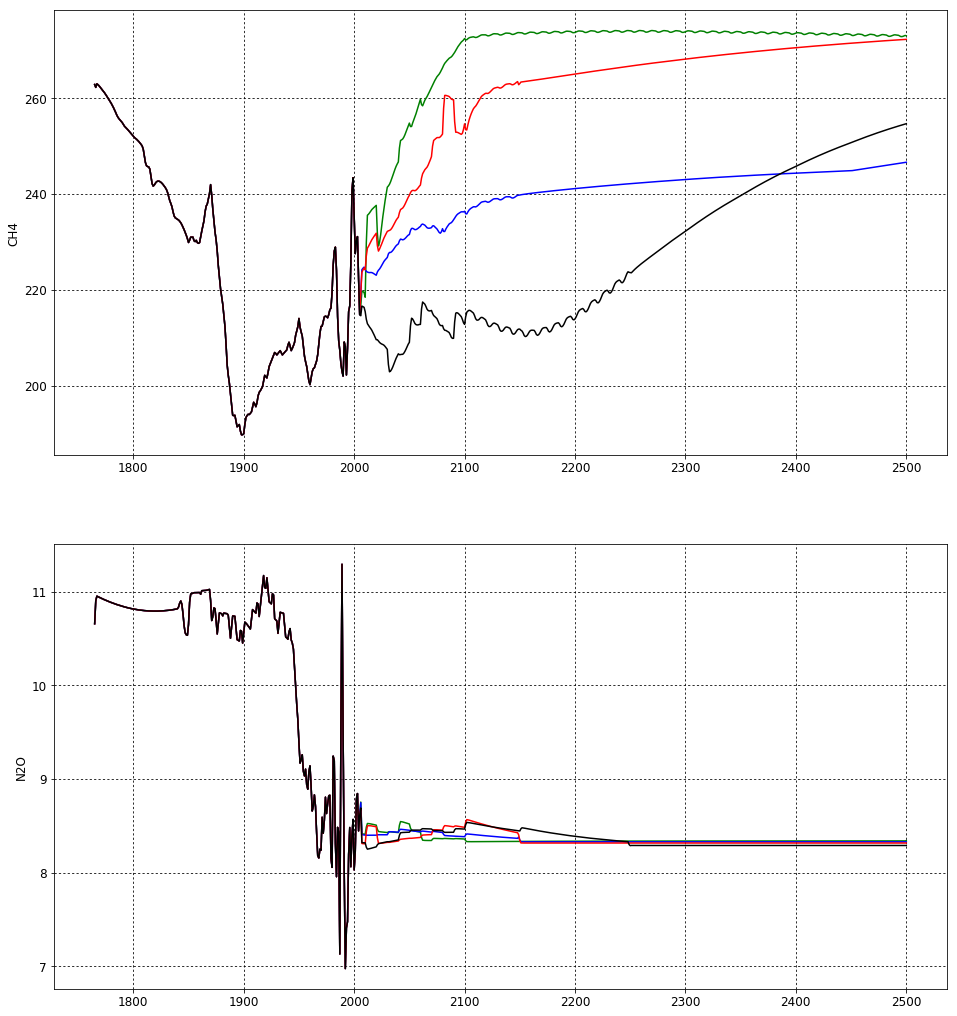

In [101]:
# Now we save to file
from scipy.ndimage.filters import gaussian_filter as smooth
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

color = ['g','b','r','black']
for i,x in enumerate(['3PD','45','6','85']):

    filename = './fair/RCPs/RCP'+ x + '_test.csv'
    nat_emms_data = np.genfromtxt(filename,skip_header=1,delimiter=',',names=True)
    
    nat_emms_CH4 = nat_emms_data['CH4']
    nat_emms_N2O = nat_emms_data['N2O']
    
    time = np.arange(1765,2501)

    ax1.plot(time,nat_emms_CH4,color = color[i])
    ax2.plot(time,nat_emms_N2O,color = color[i])
    ax1.set_ylabel('CH4')
    ax2.set_ylabel('N2O')